<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#import-libs" data-toc-modified-id="import-libs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>import libs</a></span></li><li><span><a href="#Train-NN" data-toc-modified-id="Train-NN-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Train NN</a></span><ul class="toc-item"><li><span><a href="#main()" data-toc-modified-id="main()-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>main()</a></span><ul class="toc-item"><li><span><a href="#Plot" data-toc-modified-id="Plot-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Plot</a></span></li></ul></li><li><span><a href="#test-example:-2d" data-toc-modified-id="test-example:-2d-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>test example: 2d</a></span><ul class="toc-item"><li><span><a href="#fully-connected-in-sklearn" data-toc-modified-id="fully-connected-in-sklearn-2.2.1"><span class="toc-item-num">2.2.1&nbsp;&nbsp;</span>fully connected in sklearn</a></span></li><li><span><a href="#fully-connected-in-keras" data-toc-modified-id="fully-connected-in-keras-2.2.2"><span class="toc-item-num">2.2.2&nbsp;&nbsp;</span>fully connected in keras</a></span></li><li><span><a href="#cnn" data-toc-modified-id="cnn-2.2.3"><span class="toc-item-num">2.2.3&nbsp;&nbsp;</span>cnn</a></span></li></ul></li></ul></li></ul></div>

# import libs

In [22]:
import configparser
confParser = configparser.ConfigParser()

#--- parse conf. file
confParser.read('configuration.ini')
print('conf. file sections:',confParser.sections())
#
import os
import sys
sys.path.append(confParser['input files']['lib_path'])
from dscribe.descriptors import SOAP, ACSF
import ase
import ase.io
import ase.build
from ase.io import lammpsdata
import pdb
import time
import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
if not eval(confParser['flags']['RemoteMachine']):
    plt.rc('text', usetex=True)
#
import sklearn
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
#
from scipy.stats import gaussian_kde
#
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow import keras
from tensorflow.keras import layers

#--- user modules
import LammpsPostProcess as lp
import utility as utl
import imp
imp.reload(utl)
imp.reload(lp)


conf. file sections: ['flags', 'input files', 'EnergyBarrier', 'neural net', 'ml mc']


<module 'LammpsPostProcess' from '../../HeaDef/postprocess/LammpsPostProcess.py'>

# Train NN

In [23]:
class NeuralNetwork():

    def __init__(self, verbose=False,
                **kwargs
                ):
        self.verbose = verbose
        for key in kwargs:
            setattr(self,key,kwargs[key])
    
    def Parse(self,path,nruns):
        self.perAtomData = {}
        rwjs = utl.ReadWriteJson()
        for irun in range(nruns):
            try:
                #--- same configurations!
                self.descriptors  = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['data']]
                self.shape        = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['shape']].flatten()
                self.positions    = np.c_[rwjs.Read('%s/Run%s/descriptors.json'%(path,irun))[0]['xyz']]
                data = np.loadtxt('%s/Run%s/perAtomData.txt'%(path,irun))
                #--- displacement data
                self.perAtomData[irun] = pd.DataFrame(np.c_[data],
                columns='id	type	x	y	z	ux	uy	uz	energy_barrier	defect_label'.split()
                            )
                os.system('ln -s %s/Run%s/dumpFile/dump.xyz .'%(path,irun))
            except:
#                 if self.verbose:
#                     traceback.print_exc()
                continue
                
        
        self.nruns = list(self.perAtomData.keys())
        self.nruns.sort()
        
    def Combine(self):
#         pdb.set_trace()
        #--- center atoms
        center_atom_indices = list(map(lambda x:NeuralNetwork.GetCenterAtom( self.perAtomData[x])[0],self.nruns))
        sdict = dict(zip(center_atom_indices,self.nruns))
        
        atom_ids = list(sdict.keys())
        atom_ids.sort()
        #         center_atom_indices = list( set( center_atom_indices ) )
        data = np.concatenate(list(map(lambda x: np.c_[self.perAtomData[sdict[x]].iloc[ x ]],atom_ids)),axis=1).T
        descriptors_center_atoms = self.descriptors[atom_ids]
    
        #--- data frame
#        print(data.shape)
        irun = self.nruns[0]
        df_combined = pd.DataFrame(data,columns=list(self.perAtomData[irun].keys()))
    
        #--- filter crystaliine atoms
        filtr = self.perAtomData[irun].defect_label == 0.0
        df_crystalline = self.perAtomData[irun][filtr]
        descriptors_crystalline = self.descriptors[filtr]

        #--- merge
        keys = list(df_combined.keys())
        data_concat = np.concatenate([np.c_[df_combined[keys]],np.c_[df_crystalline[keys]]],axis=0) 
        self.perAtomData = pd.DataFrame(data_concat,
                              columns=keys
                             )

        
        #--- merge descriptors
        self.descriptors = np.concatenate([descriptors_center_atoms,descriptors_crystalline],axis=0)

        assert self.perAtomData.shape[ 0 ] == self.descriptors.shape[0], 'need more mc swaps: %s %s'\
        %(self.perAtomData.shape[ 0 ],self.descriptors.shape[0])
                            
                                 
    
    @staticmethod
    def GetCenterAtom(df):
        disp_magnitude = df.ux**2+df.uy**2+df.uz**2
        center_atom_indx = disp_magnitude.sort_values(ascending=False).index[0]
        return center_atom_indx, int(df.iloc[ center_atom_indx ].id)

    @staticmethod
    def zscore(slist):
        tmp = np.copy(slist)
        print(np.mean(tmp),np.std(tmp))
        tmp -= np.mean(tmp)
        tmp /= np.std(tmp)
        return tmp

    def PCA(self,
           n_components=2,
            random_state = 1,
           ):
        #--- concat. data
        X = self.descriptors
        pca = PCA(n_components=n_components,random_state=random_state)
        pca.fit(X)
        X_transformed = pca.transform(X)

        xdata = X_transformed[:,0]
        ydata = X_transformed[:,1]
        #
        filtr_defects = self.perAtomData.defect_label == 0.0
        #

        legend = utl.Legends()
        legend.Set(bbox_to_anchor=(1.1,.5, 0.5, 0.5))
#         pdb.set_trace()
        #ax = utl.PltErr(zscore(xdata)[filtr_defects],zscore(ydata)[filtr_defects],
        ax = utl.PltErr(xdata[filtr_defects],ydata[filtr_defects],
                  attrs={'fmt':'x','alpha':1,'label':'defect_free'},
                        Plot = False,
        #                 xlim=(-2,2),
        #                 ylim=(-2,2),
                  )

        #utl.PltErr(zscore(xdata)[~filtr_defects],zscore(ydata)[~filtr_defects],
        !mkdir png
        utl.PltErr(xdata[~filtr_defects],ydata[~filtr_defects],
                  attrs={'fmt':'.','color':'red','label':'defects'},
                   ax=ax,
                   xstr='pca_1',ystr='pca_2',
                   legend = legend.Get(),
                   title='png/pca.png'
                  )
    def Spectra(self,
               nrows=100,
               ):
        assert nrows <= self.descriptors.shape[ 0 ]
        !mkdir png
        utl.PltBitmap(np.log10(np.abs(self.descriptors[:nrows,:])),
                      xlabel=r'$\mathrm{ndim}$',ylabel=r'$\mathrm{natom}$',
                      xlim=(0,self.descriptors.shape[1]),
                      ylim=(0,nrows),
                      colorbar=True,
                      zscore=False,
                      vminmax=(-3,3),
                      title='png/feature_bitmap.png'
                     )
        
    def TrainClassifier(self,y,
                       random_state=1,
                       ):
        #--- train-test split
        X = np.c_[self.descriptors]
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        #--- tune parameters
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
                         #'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
                        'alpha':self.alpha, #--- regularization 
                         #'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,

                     } 

        #--- train
        mlp = MLPClassifier(random_state=random_state)
        clf = GridSearchCV(mlp, param_grid)
        clf.fit(X_train,y_train)

        #--- validate
        !mkdir png
        utl.PltErr(range(len(clf.best_estimator_.loss_curve_)), clf.best_estimator_.loss_curve_,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )


        #--- confusion matrix
        cm = confusion_matrix(y_test, clf.predict(X_test),
                         labels=[0, 1]
                        )
        print('cm=',cm)

    def TrainRegressor(self,stratify,y,
                       random_state=1,
                       printOvito = False,
                       filtr = None,
                       ):
        '''
        Multi-layer Perceptron regressor.

        Parameters
        ----------
        stratify : array-like, default=None
        If not None, data is split in a stratified fashion, using this as
        the class labels.
        
        y : array-like, target data
        
        random_state : initial seed, default=1
        
        printOvito : bool, default=False
        
        filtr : bool, default=False
        if not None, data is filtered before calling train-test split
        '''
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        
        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors[filtr]]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=stratify,
                                                            random_state=random_state)

        #-----------------------
        #--- parameter grid
        #-----------------------
        param_grid = {
                        'hidden_layer_sizes':self.hidden_layer_sizes,
                         #'activation' : ['tanh', 'relu'],
                         'learning_rate_init':self.learning_rate_init,
                        'alpha':self.alpha, #--- regularization 
                         #'learning_rate' : ['invscaling', 'adaptive'],
                        'n_iter_no_change':self.n_iter_no_change,
                        'tol':self.tol,
                        'max_iter':self.max_iter,
                     } 

        #-----------------------
        #--- train model
        #-----------------------
        if self.fully_connected: #--- dense nn
            if self.implementation == 'sklearn':
                mlp   =  MLPRegressor(random_state=random_state,verbose=self.verbose) #--- mlp regressor
                regr  =  GridSearchCV(mlp, param_grid)
                regr.fit(X_train,y_train)
                model =  regr.best_estimator_
                loss  =  model.loss_curve_
                
            elif self.implementation == 'keras': #--- dense nn in keras
                model     = keras.Sequential([ #--- The network architecture
                    layers.Dense(self.hidden_layer_size), #activation="relu"),
                    layers.Dense(self.hidden_layer_size), #activation="relu"),
                    #layers.Dense(1000), #activation="relu"),
                    layers.Dense(ndime) #, activation="relu")
                    ])
                optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4) #--- compilation step
                model.compile( optimizer=optimizer,#"rmsprop",
                               loss="mean_squared_error",#"sparse_categorical_crossentropy",
                               metrics=["mse"]
                             )
                model.fit(X_train, y_train, #--- “Fitting”
                          validation_data=(X_test, y_test),
                          epochs=self.max_iter[0], verbose=self.verbose)#, batch_size=128)
                loss      = model.history.history['loss']
                val_loss  = model.history.history['val_loss']
                
        elif self.cnn: #--- convolutional
            (model, loss, val_loss), (X_train, X_test) =\
            self.ConvNetwork(X_train, y_train, X_test, y_test )
            

        #-----------------------
        #--- validation
        #-----------------------
        !mkdir png         #--- plot validation loss 
        ax = utl.PltErr(range(len(val_loss)), val_loss,
                   attrs={'fmt':'-'}, Plot=False,
                  )
        utl.PltErr(range(len(loss)), loss,
                   attrs={'fmt':'-'},
                   ax=ax,
                   yscale='log',xscale='log',
                   xlim=(1,self.max_iter[0]),
                   xstr='epoch',ystr='loss',
                   title='png/loss.png',
                  )
        
        np.savetxt('png/loss.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')
        
        #--- plot predictions
        y_pred       = model.predict(X_test)        
        y_pred_train = model.predict(X_train)        
        for idime, xstr in zip(range(3),'ux uy uz'.split()):
            ax = utl.PltErr(None,None,Plot=False)
            #
            utl.PltErr(y_test[:,idime],y_pred[:,idime],
                       attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
                       attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
                       ax=ax,
                       Plot = False,

                      )
            #
            utl.PltErr(None,None,Plot=False,
                           title='png/scatter%s.png'%idime,
                            ax=ax,
                       xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
                       xlim=(-2,2),ylim=(-2,2),
                           )
        
        #--- save in ovito
        if printOvito:
            X_train, X_test, _, _ = train_test_split(self.perAtomData[filtr]['id type x y z'.split()], y, stratify=stratify,
                                                    random_state=random_state)
#            pdb.set_trace()
            with open('original.xyz','w') as fp:
                utl.PrintOvito(self.perAtomData[filtr], fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('train.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_train,y_pred_train],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
            with open('test.xyz','w') as fp:
                cordc = pd.DataFrame(np.c_[X_test,y_pred],columns='id type x y z ux uy uz'.split())
                utl.PrintOvito(cordc, fp, '0', attr_list='id type x y z ux uy uz'.split())
                

    def ConvNetwork(self,X_train, y_train, X_test, y_test):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
#         tf.random.set_random_seed(812)

        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #

        #------------------------------
        #--- The network architecture
        #------------------------------
        x             =  layers.Conv3D(   filters     =  filters, 
                                          kernel_size =  kernel_size,
                                          activation  =  activation,
                                          padding     =  padding
                                       )(inputs)
        filters       *=  2
        for i in range( self.number_hidden_layers ):
            x       = layers.AveragePooling3D( pool_size = 2 )( x )
            x       = layers.Conv3D( filters       =  filters, 
                                     kernel_size   =  kernel_size,
                                     activation    =  activation,
                                     padding       =  padding
                                     )(x)
            filters *= 2
            
        #--- output layer
        x       = layers.Flatten()(x)
        outputs = layers.Dense( ndime, activation=activation)(x)
        model   = keras.Model(inputs=inputs, outputs=outputs)
        if self.verbose:
            print('cnn model summary:',model.summary())

        #--- The compilation step
        optimizer = tf.keras.optimizers.Adam( learning_rate = learning_rate )
        model.compile( optimizer =  optimizer,
                       loss      =  "mean_squared_error",
                       metrics   =  ["mse"]
                     )

        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnet_from_scratch.tf',  
                                                   monitor="loss",
                                                  save_freq=10,
                                                    save_best_only=True)]

        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train.reshape((n_train,shape[0],shape[1],shape[2],1))
        X_test_reshaped  =  X_test.reshape((n_test,shape[0],shape[1],shape[2],1))
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                   callbacks            = callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
                    use_multiprocessing = True,
                    workers             = 4,
                 )

        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnet_from_scratch.tf")

        
        return ( best_model, loss, val_loss ), (X_train_reshaped, X_test_reshaped)
    

    def ConvNetworkClassifier(self,y,
                               random_state=1
                               ):
        '''
        Convolutional neural network.

        Parameters
        ----------
        X_train : array-like training x input
        
        y_train : array-like, training y input
        
        X_test : array-like test x input
        
        y_test : array-like, training y input

        Return
        ---------- ( , loss,  )
        best_model : cnn object, best trained model based on on the validation loss
        
        loss : array-like, mse loss

        val_loss : array-like, validation loss

        '''
        
        if self.verbose:
            print('dim(y)=',y.shape)

        ndime  = y.shape[1] #--- dimension of the target vector
        

        #---------------
        #--- zscore X
        #---------------        
        X      = np.c_[self.descriptors ]
        scaler = StandardScaler()
        scaler.fit(X)
        X      = scaler.transform( X )
    
        if self.verbose:
            print('X.shape:=',X.shape)
            
            
            
        #-----------------------
        #--- train-test split
        #-----------------------
        X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,
                                                            random_state=random_state)

        
        
        #---- set model parameters
        shape         =  (self.shape[0],self.shape[1],self.shape[2],1) #--- rows, cols, thickness, channels
        kernel_size   =  self.kernel_size 
        epochs        =  100 #self.max_iter[0]
        activation    =  self.activation
        padding       = 'same'
        filters       =  self.n_channels
        learning_rate = self.learning_rate_init[0]
        #
        ndime         =  y_train.shape[1]
        n_train       =  X_train.shape[0]
        n_test        =  X_test.shape[0]
        assert        shape[0] * shape[1] * shape[2] == X_train.shape[ 1 ]
        inputs        =  keras.Input(shape=shape)
        #
#         pdb.set_trace()
        #------------------------------
        #--- The network architecture
        #------------------------------
        model     = keras.Sequential([
            layers.Dense(self.hidden_layer_size, activation="relu"),
#             layers.Dense(self.hidden_layer_size), #activation="relu"),
            layers.Dense(2, activation="softmax")
            ])
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate) #--- compilation step

        model.compile( optimizer="rmsprop",
                       loss="sparse_categorical_crossentropy",
                       metrics=["mse"])

        #--- save best model
        !mkdir best_model
        callbacks=[keras.callbacks.ModelCheckpoint( filepath='best_model/convnetClassifier_from_scratch.tf',  
                                                    monitor="loss",
                                                    save_freq=10,
                                                    save_best_only=True)]


        #--- “Fitting” the model X_train_transfrmd, y_train
        X_train_reshaped =  X_train 
        X_test_reshaped  =  X_test
        model.fit( X_train_reshaped, y_train, 
                   validation_data      = ( X_test_reshaped, y_test ),
                    callbacks=callbacks,
                    epochs              = epochs, 
                    verbose             = self.verbose, 
                    shuffle             = False, 
#                     batch_size     = 128,
                    use_multiprocessing = True,
                    workers             = 4,
                 )        




        #--- validation loss
        loss       = model.history.history['loss']
        val_loss   = model.history.history['val_loss']
        best_model = keras.models.load_model("best_model/convnetClassifier_from_scratch.tf")

        
        !mkdir png
        utl.PltErr(range(len(val_loss)), val_loss,
                   yscale='log',
                   xstr='epoch',ystr='loss',
                   title='png/val_loss_classification.png',
                  )
        
        np.savetxt('png/val_loss_classification.txt',np.c_[range(len(loss)),loss,val_loss],header='epoch loss val_loss')


#         pdb.set_trace()
        #--- confusion matrix
        predict_x = best_model.predict(X_test) 
        classes_x = np.argmax(predict_x,axis=1)
        cm = confusion_matrix(y_test, classes_x,
                         labels=[0, 1]
                        )
        print('cm=',cm)
        np.savetxt('png/confusion.txt',np.c_[cm])
    

    
    def PrintDensityMap(self, atomIndx, fout):
        with open(fout,'w') as fp:
                    disp           = np.c_[self.perAtomData.iloc[atomIndx]['ux uy uz'.split()]].flatten()
                    df             = pd.DataFrame(np.c_[self.positions.T,self.descriptors[atomIndx]],
                                                  columns='x y z mass'.split())
                    utl.PrintOvito(df, fp, 'disp = %s'%disp, attr_list='x y z mass'.split())
#     def SaveConf(self,fout):
#         with open(fout,'w') as fp:
#             np.savetxt(fp,np.c_[self.perAtomData],header=' '.join(list(self.perAtomData.keys())))

## main()

dim(y)= (1366, 1)
X.shape:= (1366, 1331)
mkdir: best_model: File exists
Train on 1024 samples, validate on 342 samples
Epoch 1/100
1024/1024 [==============================] - 5s 5ms/sample - loss: 0.0691 - mean_squared_error: 0.4819 - val_loss: 0.0011 - val_mean_squared_error: 0.4989
Epoch 2/100
1024/1024 [==============================] - 3s 3ms/sample - loss: 4.9637e-04 - mean_squared_error: 0.4995 - val_loss: 1.7023e-04 - val_mean_squared_error: 0.4998
Epoch 3/100
1024/1024 [==============================] - 4s 4ms/sample - loss: 7.5072e-05 - mean_squared_error: 0.4999 - val_loss: 2.7341e-05 - val_mean_squared_error: 0.5000
Epoch 4/100
1024/1024 [==============================] - 5s 5ms/sample - loss: 1.1980e-05 - mean_squared_error: 0.5000 - val_loss: 5.0214e-06 - val_mean_squared_error: 0.5000
Epoch 5/100
1024/1024 [==============================] - 2s 2ms/sample - loss: 2.2051e-06 - mean_squared_error: 0.5000 - val_loss: 1.1175e-06 - val_mean_squared_error: 0.5000
Epoch 6/100
10

1024/1024 [==============================] - 1s 686us/sample - loss: 3.4925e-10 - mean_squared_error: 0.5000 - val_loss: 1.7428e-09 - val_mean_squared_error: 0.5000
Epoch 23/100
1024/1024 [==============================] - 1s 635us/sample - loss: 3.4925e-10 - mean_squared_error: 0.5000 - val_loss: 1.7428e-09 - val_mean_squared_error: 0.5000
Epoch 24/100
1024/1024 [==============================] - 1s 689us/sample - loss: 3.4925e-10 - mean_squared_error: 0.5000 - val_loss: 1.7428e-09 - val_mean_squared_error: 0.5000
Epoch 25/100
1024/1024 [==============================] - 1s 610us/sample - loss: 3.4925e-10 - mean_squared_error: 0.5000 - val_loss: 1.7428e-09 - val_mean_squared_error: 0.5000
Epoch 26/100
1024/1024 [==============================] - 1s 680us/sample - loss: 3.4925e-10 - mean_squared_error: 0.5000 - val_loss: 1.3943e-09 - val_mean_squared_error: 0.5000
Epoch 27/100
1024/1024 [==============================] - 1s 618us/sample - loss: 3.4925e-10 - mean_squared_error: 0.5000 -

1024/1024 [==============================] - 1s 814us/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 3.4857e-10 - val_mean_squared_error: 0.5000
Epoch 69/100
1024/1024 [==============================] - 1s 738us/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 3.4857e-10 - val_mean_squared_error: 0.5000
Epoch 70/100
1024/1024 [==============================] - 1s 610us/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 3.4857e-10 - val_mean_squared_error: 0.5000
Epoch 71/100
1024/1024 [==============================] - 1s 605us/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 3.4857e-10 - val_mean_squared_error: 0.5000
Epoch 72/100
1024/1024 [==============================] - 1s 576us/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 - val_loss: 3.4857e-10 - val_mean_squared_error: 0.5000
Epoch 73/100
1024/1024 [==============================] - 1s 762us/sample - loss: 0.0000e+00 - mean_squared_error: 0.5000 -

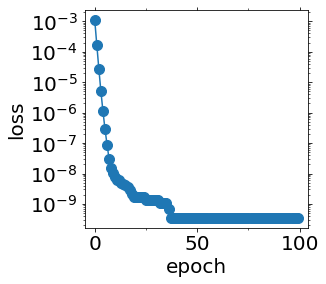

cm= [[340   0]
 [  0   2]]
dim(y)= (7, 3)
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 11, 11, 11, 1)]   0         
_________________________________________________________________
conv3d_4 (Conv3D)            (None, 11, 11, 11, 16)    448       
_________________________________________________________________
average_pooling3d_3 (Average (None, 5, 5, 5, 16)       0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 5, 5, 5, 32)       13856     
_________________________________________________________________
average_pooling3d_4 (Average (None, 2, 2, 2, 32)       0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 2, 2, 2, 64)       55360     
_________________________________________________________________
average_pooling3d

5/5 [==============================] - 0s 45ms/sample - loss: 1.9774 - mean_squared_error: 1.9774 - val_loss: 1.9903 - val_mean_squared_error: 1.9903
Epoch 31/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.9771 - mean_squared_error: 1.9771 - val_loss: 1.9904 - val_mean_squared_error: 1.9904
Epoch 32/2000
5/5 [==============================] - 0s 50ms/sample - loss: 1.9768 - mean_squared_error: 1.9768 - val_loss: 1.9904 - val_mean_squared_error: 1.9904
Epoch 33/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9764 - mean_squared_error: 1.9764 - val_loss: 1.9905 - val_mean_squared_error: 1.9905
Epoch 34/2000
5/5 [==============================] - 0s 23ms/sample - loss: 1.9761 - mean_squared_error: 1.9761 - val_loss: 1.9905 - val_mean_squared_error: 1.9905
Epoch 35/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.9757 - mean_squared_error: 1.9757 - val_loss: 1.9906 - val_mean_squared_error: 1.9906
Epoch 36/2000
5/5 [==============

5/5 [==============================] - 0s 48ms/sample - loss: 1.9631 - mean_squared_error: 1.9631 - val_loss: 1.9919 - val_mean_squared_error: 1.9919
Epoch 69/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.9626 - mean_squared_error: 1.9626 - val_loss: 1.9919 - val_mean_squared_error: 1.9919
Epoch 70/2000
5/5 [==============================] - 0s 59ms/sample - loss: 1.9622 - mean_squared_error: 1.9622 - val_loss: 1.9920 - val_mean_squared_error: 1.9920
Epoch 71/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9617 - mean_squared_error: 1.9617 - val_loss: 1.9920 - val_mean_squared_error: 1.9920
Epoch 72/2000
5/5 [==============================] - 0s 22ms/sample - loss: 1.9613 - mean_squared_error: 1.9613 - val_loss: 1.9920 - val_mean_squared_error: 1.9920
Epoch 73/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9608 - mean_squared_error: 1.9608 - val_loss: 1.9920 - val_mean_squared_error: 1.9920
Epoch 74/2000
5/5 [==============

Epoch 107/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9424 - mean_squared_error: 1.9424 - val_loss: 1.9922 - val_mean_squared_error: 1.9922
Epoch 108/2000
5/5 [==============================] - 0s 31ms/sample - loss: 1.9417 - mean_squared_error: 1.9417 - val_loss: 1.9922 - val_mean_squared_error: 1.9922
Epoch 109/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.9410 - mean_squared_error: 1.9410 - val_loss: 1.9921 - val_mean_squared_error: 1.9921
Epoch 110/2000
5/5 [==============================] - 0s 38ms/sample - loss: 1.9404 - mean_squared_error: 1.9404 - val_loss: 1.9921 - val_mean_squared_error: 1.9921
Epoch 111/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9397 - mean_squared_error: 1.9397 - val_loss: 1.9921 - val_mean_squared_error: 1.9921
Epoch 112/2000
5/5 [==============================] - 0s 38ms/sample - loss: 1.9390 - mean_squared_error: 1.9390 - val_loss: 1.9921 - val_mean_squared_error: 1.9921
Epoch 113/200

5/5 [==============================] - 0s 29ms/sample - loss: 1.9103 - mean_squared_error: 1.9103 - val_loss: 1.9899 - val_mean_squared_error: 1.9899
Epoch 147/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9093 - mean_squared_error: 1.9093 - val_loss: 1.9898 - val_mean_squared_error: 1.9898
Epoch 148/2000
5/5 [==============================] - 0s 51ms/sample - loss: 1.9083 - mean_squared_error: 1.9083 - val_loss: 1.9897 - val_mean_squared_error: 1.9897
Epoch 149/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.9072 - mean_squared_error: 1.9072 - val_loss: 1.9896 - val_mean_squared_error: 1.9896
Epoch 150/2000
5/5 [==============================] - 0s 22ms/sample - loss: 1.9061 - mean_squared_error: 1.9061 - val_loss: 1.9895 - val_mean_squared_error: 1.9895
Epoch 151/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.9050 - mean_squared_error: 1.9050 - val_loss: 1.9894 - val_mean_squared_error: 1.9894
Epoch 152/2000
5/5 [========

Epoch 186/2000
5/5 [==============================] - 0s 19ms/sample - loss: 1.8577 - mean_squared_error: 1.8577 - val_loss: 1.9832 - val_mean_squared_error: 1.9832
Epoch 187/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.8560 - mean_squared_error: 1.8560 - val_loss: 1.9829 - val_mean_squared_error: 1.9829
Epoch 188/2000
5/5 [==============================] - 0s 30ms/sample - loss: 1.8544 - mean_squared_error: 1.8544 - val_loss: 1.9827 - val_mean_squared_error: 1.9827
Epoch 189/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.8527 - mean_squared_error: 1.8527 - val_loss: 1.9824 - val_mean_squared_error: 1.9824
Epoch 190/2000
5/5 [==============================] - 0s 52ms/sample - loss: 1.8509 - mean_squared_error: 1.8509 - val_loss: 1.9822 - val_mean_squared_error: 1.9822
Epoch 191/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.8492 - mean_squared_error: 1.8492 - val_loss: 1.9819 - val_mean_squared_error: 1.9819
Epoch 192/200

Epoch 224/2000
5/5 [==============================] - 0s 34ms/sample - loss: 1.7799 - mean_squared_error: 1.7799 - val_loss: 1.9704 - val_mean_squared_error: 1.9704
Epoch 225/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.7774 - mean_squared_error: 1.7774 - val_loss: 1.9700 - val_mean_squared_error: 1.9700
Epoch 226/2000
5/5 [==============================] - 0s 31ms/sample - loss: 1.7749 - mean_squared_error: 1.7749 - val_loss: 1.9695 - val_mean_squared_error: 1.9695
Epoch 227/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.7723 - mean_squared_error: 1.7723 - val_loss: 1.9691 - val_mean_squared_error: 1.9691
Epoch 228/2000
5/5 [==============================] - 0s 40ms/sample - loss: 1.7698 - mean_squared_error: 1.7698 - val_loss: 1.9686 - val_mean_squared_error: 1.9686
Epoch 229/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.7672 - mean_squared_error: 1.7672 - val_loss: 1.9682 - val_mean_squared_error: 1.9682
Epoch 230/200

Epoch 264/2000
5/5 [==============================] - 0s 40ms/sample - loss: 1.6606 - mean_squared_error: 1.6606 - val_loss: 1.9480 - val_mean_squared_error: 1.9480
Epoch 265/2000
5/5 [==============================] - 0s 9ms/sample - loss: 1.6571 - mean_squared_error: 1.6571 - val_loss: 1.9473 - val_mean_squared_error: 1.9473
Epoch 266/2000
5/5 [==============================] - 0s 78ms/sample - loss: 1.6535 - mean_squared_error: 1.6535 - val_loss: 1.9466 - val_mean_squared_error: 1.9466
Epoch 267/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.6500 - mean_squared_error: 1.6500 - val_loss: 1.9459 - val_mean_squared_error: 1.9459
Epoch 268/2000
5/5 [==============================] - 0s 58ms/sample - loss: 1.6464 - mean_squared_error: 1.6464 - val_loss: 1.9452 - val_mean_squared_error: 1.9452
Epoch 269/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.6428 - mean_squared_error: 1.6428 - val_loss: 1.9444 - val_mean_squared_error: 1.9444
Epoch 270/200

Epoch 301/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.5165 - mean_squared_error: 1.5165 - val_loss: 1.9178 - val_mean_squared_error: 1.9178
Epoch 302/2000
5/5 [==============================] - 0s 36ms/sample - loss: 1.5122 - mean_squared_error: 1.5122 - val_loss: 1.9169 - val_mean_squared_error: 1.9169
Epoch 303/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.5079 - mean_squared_error: 1.5079 - val_loss: 1.9159 - val_mean_squared_error: 1.9159
Epoch 304/2000
5/5 [==============================] - 0s 35ms/sample - loss: 1.5037 - mean_squared_error: 1.5037 - val_loss: 1.9150 - val_mean_squared_error: 1.9150
Epoch 305/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.4994 - mean_squared_error: 1.4994 - val_loss: 1.9140 - val_mean_squared_error: 1.9140
Epoch 306/2000
5/5 [==============================] - 0s 39ms/sample - loss: 1.4951 - mean_squared_error: 1.4951 - val_loss: 1.9130 - val_mean_squared_error: 1.9130
Epoch 307/200

Epoch 338/2000
5/5 [==============================] - 0s 58ms/sample - loss: 1.3542 - mean_squared_error: 1.3542 - val_loss: 1.8795 - val_mean_squared_error: 1.8795
Epoch 339/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.3498 - mean_squared_error: 1.3498 - val_loss: 1.8784 - val_mean_squared_error: 1.8784
Epoch 340/2000
5/5 [==============================] - 0s 55ms/sample - loss: 1.3454 - mean_squared_error: 1.3454 - val_loss: 1.8773 - val_mean_squared_error: 1.8773
Epoch 341/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.3410 - mean_squared_error: 1.3410 - val_loss: 1.8761 - val_mean_squared_error: 1.8761
Epoch 342/2000
5/5 [==============================] - 0s 56ms/sample - loss: 1.3366 - mean_squared_error: 1.3366 - val_loss: 1.8750 - val_mean_squared_error: 1.8750
Epoch 343/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.3323 - mean_squared_error: 1.3323 - val_loss: 1.8739 - val_mean_squared_error: 1.8739
Epoch 344/200

Epoch 375/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.2000 - mean_squared_error: 1.2000 - val_loss: 1.8368 - val_mean_squared_error: 1.8368
Epoch 376/2000
5/5 [==============================] - 0s 44ms/sample - loss: 1.1962 - mean_squared_error: 1.1962 - val_loss: 1.8357 - val_mean_squared_error: 1.8357
Epoch 377/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.1924 - mean_squared_error: 1.1924 - val_loss: 1.8345 - val_mean_squared_error: 1.8345
Epoch 378/2000
5/5 [==============================] - 0s 56ms/sample - loss: 1.1886 - mean_squared_error: 1.1886 - val_loss: 1.8333 - val_mean_squared_error: 1.8333
Epoch 379/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.1849 - mean_squared_error: 1.1849 - val_loss: 1.8322 - val_mean_squared_error: 1.8322
Epoch 380/2000
5/5 [==============================] - 0s 51ms/sample - loss: 1.1812 - mean_squared_error: 1.1812 - val_loss: 1.8310 - val_mean_squared_error: 1.8310
Epoch 381/200

Epoch 418/2000
5/5 [==============================] - 0s 58ms/sample - loss: 1.0583 - mean_squared_error: 1.0583 - val_loss: 1.7891 - val_mean_squared_error: 1.7891
Epoch 419/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.0555 - mean_squared_error: 1.0555 - val_loss: 1.7881 - val_mean_squared_error: 1.7881
Epoch 420/2000
5/5 [==============================] - 0s 25ms/sample - loss: 1.0527 - mean_squared_error: 1.0527 - val_loss: 1.7870 - val_mean_squared_error: 1.7870
Epoch 421/2000
5/5 [==============================] - 0s 4ms/sample - loss: 1.0500 - mean_squared_error: 1.0500 - val_loss: 1.7860 - val_mean_squared_error: 1.7860
Epoch 422/2000
5/5 [==============================] - 0s 26ms/sample - loss: 1.0473 - mean_squared_error: 1.0473 - val_loss: 1.7850 - val_mean_squared_error: 1.7850
Epoch 423/2000
5/5 [==============================] - 0s 5ms/sample - loss: 1.0446 - mean_squared_error: 1.0446 - val_loss: 1.7840 - val_mean_squared_error: 1.7840
Epoch 424/200

Epoch 455/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.9669 - mean_squared_error: 0.9669 - val_loss: 1.7538 - val_mean_squared_error: 1.7538
Epoch 456/2000
5/5 [==============================] - 0s 42ms/sample - loss: 0.9647 - mean_squared_error: 0.9647 - val_loss: 1.7530 - val_mean_squared_error: 1.7530
Epoch 457/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.9625 - mean_squared_error: 0.9625 - val_loss: 1.7521 - val_mean_squared_error: 1.7521
Epoch 458/2000
5/5 [==============================] - 0s 45ms/sample - loss: 0.9603 - mean_squared_error: 0.9603 - val_loss: 1.7512 - val_mean_squared_error: 1.7512
Epoch 459/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.9581 - mean_squared_error: 0.9581 - val_loss: 1.7503 - val_mean_squared_error: 1.7503
Epoch 460/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.9560 - mean_squared_error: 0.9560 - val_loss: 1.7495 - val_mean_squared_error: 1.7495
Epoch 461/200

5/5 [==============================] - 0s 26ms/sample - loss: 0.8862 - mean_squared_error: 0.8862 - val_loss: 1.7218 - val_mean_squared_error: 1.7218
Epoch 495/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.8842 - mean_squared_error: 0.8842 - val_loss: 1.7210 - val_mean_squared_error: 1.7210
Epoch 496/2000
5/5 [==============================] - 0s 17ms/sample - loss: 0.8823 - mean_squared_error: 0.8823 - val_loss: 1.7202 - val_mean_squared_error: 1.7202
Epoch 497/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.8803 - mean_squared_error: 0.8803 - val_loss: 1.7195 - val_mean_squared_error: 1.7195
Epoch 498/2000
5/5 [==============================] - 0s 45ms/sample - loss: 0.8784 - mean_squared_error: 0.8784 - val_loss: 1.7187 - val_mean_squared_error: 1.7187
Epoch 499/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.8764 - mean_squared_error: 0.8764 - val_loss: 1.7179 - val_mean_squared_error: 1.7179
Epoch 500/2000
5/5 [========

5/5 [==============================] - 0s 38ms/sample - loss: 0.8101 - mean_squared_error: 0.8101 - val_loss: 1.6914 - val_mean_squared_error: 1.6914
Epoch 535/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.8082 - mean_squared_error: 0.8082 - val_loss: 1.6907 - val_mean_squared_error: 1.6907
Epoch 536/2000
5/5 [==============================] - 0s 22ms/sample - loss: 0.8064 - mean_squared_error: 0.8064 - val_loss: 1.6899 - val_mean_squared_error: 1.6899
Epoch 537/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.8045 - mean_squared_error: 0.8045 - val_loss: 1.6892 - val_mean_squared_error: 1.6892
Epoch 538/2000
5/5 [==============================] - 0s 25ms/sample - loss: 0.8027 - mean_squared_error: 0.8027 - val_loss: 1.6884 - val_mean_squared_error: 1.6884
Epoch 539/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.8008 - mean_squared_error: 0.8008 - val_loss: 1.6877 - val_mean_squared_error: 1.6877
Epoch 540/2000
5/5 [========

Epoch 574/2000
5/5 [==============================] - 0s 50ms/sample - loss: 0.7366 - mean_squared_error: 0.7366 - val_loss: 1.6609 - val_mean_squared_error: 1.6609
Epoch 575/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.7347 - mean_squared_error: 0.7347 - val_loss: 1.6601 - val_mean_squared_error: 1.6601
Epoch 576/2000
5/5 [==============================] - 0s 40ms/sample - loss: 0.7329 - mean_squared_error: 0.7329 - val_loss: 1.6593 - val_mean_squared_error: 1.6593
Epoch 577/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.7311 - mean_squared_error: 0.7311 - val_loss: 1.6585 - val_mean_squared_error: 1.6585
Epoch 578/2000
5/5 [==============================] - 0s 18ms/sample - loss: 0.7293 - mean_squared_error: 0.7293 - val_loss: 1.6577 - val_mean_squared_error: 1.6577
Epoch 579/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.7274 - mean_squared_error: 0.7274 - val_loss: 1.6569 - val_mean_squared_error: 1.6569
Epoch 580/200

Epoch 613/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.6653 - mean_squared_error: 0.6653 - val_loss: 1.6290 - val_mean_squared_error: 1.6290
Epoch 614/2000
5/5 [==============================] - 0s 38ms/sample - loss: 0.6635 - mean_squared_error: 0.6635 - val_loss: 1.6282 - val_mean_squared_error: 1.6282
Epoch 615/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.6616 - mean_squared_error: 0.6616 - val_loss: 1.6273 - val_mean_squared_error: 1.6273
Epoch 616/2000
5/5 [==============================] - 0s 26ms/sample - loss: 0.6598 - mean_squared_error: 0.6598 - val_loss: 1.6265 - val_mean_squared_error: 1.6265
Epoch 617/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.6580 - mean_squared_error: 0.6580 - val_loss: 1.6256 - val_mean_squared_error: 1.6256
Epoch 618/2000
5/5 [==============================] - 0s 39ms/sample - loss: 0.6561 - mean_squared_error: 0.6561 - val_loss: 1.6248 - val_mean_squared_error: 1.6248
Epoch 619/200

5/5 [==============================] - 0s 32ms/sample - loss: 0.5934 - mean_squared_error: 0.5934 - val_loss: 1.5940 - val_mean_squared_error: 1.5940
Epoch 653/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.5915 - mean_squared_error: 0.5915 - val_loss: 1.5930 - val_mean_squared_error: 1.5930
Epoch 654/2000
5/5 [==============================] - 0s 29ms/sample - loss: 0.5896 - mean_squared_error: 0.5896 - val_loss: 1.5921 - val_mean_squared_error: 1.5921
Epoch 655/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.5878 - mean_squared_error: 0.5878 - val_loss: 1.5911 - val_mean_squared_error: 1.5911
Epoch 656/2000
5/5 [==============================] - 0s 30ms/sample - loss: 0.5859 - mean_squared_error: 0.5859 - val_loss: 1.5902 - val_mean_squared_error: 1.5902
Epoch 657/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.5841 - mean_squared_error: 0.5841 - val_loss: 1.5892 - val_mean_squared_error: 1.5892
Epoch 658/2000
5/5 [========

Epoch 689/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.5242 - mean_squared_error: 0.5242 - val_loss: 1.5570 - val_mean_squared_error: 1.5570
Epoch 690/2000
5/5 [==============================] - 0s 32ms/sample - loss: 0.5224 - mean_squared_error: 0.5224 - val_loss: 1.5560 - val_mean_squared_error: 1.5560
Epoch 691/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.5205 - mean_squared_error: 0.5205 - val_loss: 1.5549 - val_mean_squared_error: 1.5549
Epoch 692/2000
5/5 [==============================] - 0s 33ms/sample - loss: 0.5186 - mean_squared_error: 0.5186 - val_loss: 1.5539 - val_mean_squared_error: 1.5539
Epoch 693/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.5167 - mean_squared_error: 0.5167 - val_loss: 1.5528 - val_mean_squared_error: 1.5528
Epoch 694/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.5149 - mean_squared_error: 0.5149 - val_loss: 1.5518 - val_mean_squared_error: 1.5518
Epoch 695/200

5/5 [==============================] - 0s 35ms/sample - loss: 0.4550 - mean_squared_error: 0.4550 - val_loss: 1.5164 - val_mean_squared_error: 1.5164
Epoch 727/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.4531 - mean_squared_error: 0.4531 - val_loss: 1.5152 - val_mean_squared_error: 1.5152
Epoch 728/2000
5/5 [==============================] - 0s 38ms/sample - loss: 0.4513 - mean_squared_error: 0.4513 - val_loss: 1.5141 - val_mean_squared_error: 1.5141
Epoch 729/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.4494 - mean_squared_error: 0.4494 - val_loss: 1.5129 - val_mean_squared_error: 1.5129
Epoch 730/2000
5/5 [==============================] - 0s 23ms/sample - loss: 0.4476 - mean_squared_error: 0.4476 - val_loss: 1.5118 - val_mean_squared_error: 1.5118
Epoch 731/2000
5/5 [==============================] - 0s 10ms/sample - loss: 0.4457 - mean_squared_error: 0.4457 - val_loss: 1.5106 - val_mean_squared_error: 1.5106
Epoch 732/2000
5/5 [=======

5/5 [==============================] - 0s 30ms/sample - loss: 0.3818 - mean_squared_error: 0.3818 - val_loss: 1.4686 - val_mean_squared_error: 1.4686
Epoch 767/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.3800 - mean_squared_error: 0.3800 - val_loss: 1.4674 - val_mean_squared_error: 1.4674
Epoch 768/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.3782 - mean_squared_error: 0.3782 - val_loss: 1.4662 - val_mean_squared_error: 1.4662
Epoch 769/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3764 - mean_squared_error: 0.3764 - val_loss: 1.4649 - val_mean_squared_error: 1.4649
Epoch 770/2000
5/5 [==============================] - 0s 45ms/sample - loss: 0.3747 - mean_squared_error: 0.3747 - val_loss: 1.4637 - val_mean_squared_error: 1.4637
Epoch 771/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.3729 - mean_squared_error: 0.3729 - val_loss: 1.4624 - val_mean_squared_error: 1.4624
Epoch 772/2000
5/5 [========

Epoch 806/2000
5/5 [==============================] - 0s 47ms/sample - loss: 0.3131 - mean_squared_error: 0.3131 - val_loss: 1.4178 - val_mean_squared_error: 1.4178
Epoch 807/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.3115 - mean_squared_error: 0.3115 - val_loss: 1.4165 - val_mean_squared_error: 1.4165
Epoch 808/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.3098 - mean_squared_error: 0.3098 - val_loss: 1.4152 - val_mean_squared_error: 1.4152
Epoch 809/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3082 - mean_squared_error: 0.3082 - val_loss: 1.4139 - val_mean_squared_error: 1.4139
Epoch 810/2000
5/5 [==============================] - 0s 23ms/sample - loss: 0.3066 - mean_squared_error: 0.3066 - val_loss: 1.4126 - val_mean_squared_error: 1.4126
Epoch 811/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.3050 - mean_squared_error: 0.3050 - val_loss: 1.4113 - val_mean_squared_error: 1.4113
Epoch 812/200

Epoch 844/2000
5/5 [==============================] - 0s 31ms/sample - loss: 0.2547 - mean_squared_error: 0.2547 - val_loss: 1.3677 - val_mean_squared_error: 1.3677
Epoch 845/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.2533 - mean_squared_error: 0.2533 - val_loss: 1.3664 - val_mean_squared_error: 1.3664
Epoch 846/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.2519 - mean_squared_error: 0.2519 - val_loss: 1.3650 - val_mean_squared_error: 1.3650
Epoch 847/2000
5/5 [==============================] - 0s 9ms/sample - loss: 0.2504 - mean_squared_error: 0.2504 - val_loss: 1.3637 - val_mean_squared_error: 1.3637
Epoch 848/2000
5/5 [==============================] - 0s 31ms/sample - loss: 0.2490 - mean_squared_error: 0.2490 - val_loss: 1.3624 - val_mean_squared_error: 1.3624
Epoch 849/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.2476 - mean_squared_error: 0.2476 - val_loss: 1.3610 - val_mean_squared_error: 1.3610
Epoch 850/200

Epoch 881/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.2062 - mean_squared_error: 0.2062 - val_loss: 1.3184 - val_mean_squared_error: 1.3184
Epoch 882/2000
5/5 [==============================] - 0s 65ms/sample - loss: 0.2050 - mean_squared_error: 0.2050 - val_loss: 1.3170 - val_mean_squared_error: 1.3170
Epoch 883/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.2038 - mean_squared_error: 0.2038 - val_loss: 1.3157 - val_mean_squared_error: 1.3157
Epoch 884/2000
5/5 [==============================] - 0s 33ms/sample - loss: 0.2027 - mean_squared_error: 0.2027 - val_loss: 1.3144 - val_mean_squared_error: 1.3144
Epoch 885/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.2015 - mean_squared_error: 0.2015 - val_loss: 1.3131 - val_mean_squared_error: 1.3131
Epoch 886/2000
5/5 [==============================] - 0s 32ms/sample - loss: 0.2003 - mean_squared_error: 0.2003 - val_loss: 1.3117 - val_mean_squared_error: 1.3117
Epoch 887/200

Epoch 919/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1658 - mean_squared_error: 0.1658 - val_loss: 1.2684 - val_mean_squared_error: 1.2684
Epoch 920/2000
5/5 [==============================] - 0s 17ms/sample - loss: 0.1648 - mean_squared_error: 0.1648 - val_loss: 1.2671 - val_mean_squared_error: 1.2671
Epoch 921/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.1639 - mean_squared_error: 0.1639 - val_loss: 1.2658 - val_mean_squared_error: 1.2658
Epoch 922/2000
5/5 [==============================] - 0s 19ms/sample - loss: 0.1630 - mean_squared_error: 0.1630 - val_loss: 1.2646 - val_mean_squared_error: 1.2646
Epoch 923/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1621 - mean_squared_error: 0.1621 - val_loss: 1.2633 - val_mean_squared_error: 1.2633
Epoch 924/2000
5/5 [==============================] - 0s 15ms/sample - loss: 0.1611 - mean_squared_error: 0.1611 - val_loss: 1.2620 - val_mean_squared_error: 1.2620
Epoch 925/200

5/5 [==============================] - 0s 30ms/sample - loss: 0.1308 - mean_squared_error: 0.1308 - val_loss: 1.2144 - val_mean_squared_error: 1.2144
Epoch 963/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.1302 - mean_squared_error: 0.1302 - val_loss: 1.2132 - val_mean_squared_error: 1.2132
Epoch 964/2000
5/5 [==============================] - 0s 36ms/sample - loss: 0.1295 - mean_squared_error: 0.1295 - val_loss: 1.2120 - val_mean_squared_error: 1.2120
Epoch 965/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1288 - mean_squared_error: 0.1288 - val_loss: 1.2108 - val_mean_squared_error: 1.2108
Epoch 966/2000
5/5 [==============================] - 0s 35ms/sample - loss: 0.1281 - mean_squared_error: 0.1281 - val_loss: 1.2096 - val_mean_squared_error: 1.2096
Epoch 967/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1275 - mean_squared_error: 0.1275 - val_loss: 1.2084 - val_mean_squared_error: 1.2084
Epoch 968/2000
5/5 [========

Epoch 1001/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1075 - mean_squared_error: 0.1075 - val_loss: 1.1692 - val_mean_squared_error: 1.1692
Epoch 1002/2000
5/5 [==============================] - 0s 19ms/sample - loss: 0.1070 - mean_squared_error: 0.1070 - val_loss: 1.1681 - val_mean_squared_error: 1.1681
Epoch 1003/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1064 - mean_squared_error: 0.1064 - val_loss: 1.1670 - val_mean_squared_error: 1.1670
Epoch 1004/2000
5/5 [==============================] - 0s 26ms/sample - loss: 0.1059 - mean_squared_error: 0.1059 - val_loss: 1.1659 - val_mean_squared_error: 1.1659
Epoch 1005/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.1054 - mean_squared_error: 0.1054 - val_loss: 1.1648 - val_mean_squared_error: 1.1648
Epoch 1006/2000
5/5 [==============================] - 0s 33ms/sample - loss: 0.1049 - mean_squared_error: 0.1049 - val_loss: 1.1637 - val_mean_squared_error: 1.1637
Epoch 1

Epoch 1041/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0896 - mean_squared_error: 0.0896 - val_loss: 1.1273 - val_mean_squared_error: 1.1273
Epoch 1042/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.0892 - mean_squared_error: 0.0892 - val_loss: 1.1263 - val_mean_squared_error: 1.1263
Epoch 1043/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0888 - mean_squared_error: 0.0888 - val_loss: 1.1254 - val_mean_squared_error: 1.1254
Epoch 1044/2000
5/5 [==============================] - 0s 41ms/sample - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 1.1244 - val_mean_squared_error: 1.1244
Epoch 1045/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0881 - mean_squared_error: 0.0881 - val_loss: 1.1234 - val_mean_squared_error: 1.1234
Epoch 1046/2000
5/5 [==============================] - 0s 24ms/sample - loss: 0.0877 - mean_squared_error: 0.0877 - val_loss: 1.1224 - val_mean_squared_error: 1.1224
Epoch 1

Epoch 1080/2000
5/5 [==============================] - 0s 39ms/sample - loss: 0.0764 - mean_squared_error: 0.0764 - val_loss: 1.0912 - val_mean_squared_error: 1.0912
Epoch 1081/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.0761 - mean_squared_error: 0.0761 - val_loss: 1.0903 - val_mean_squared_error: 1.0903
Epoch 1082/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.0758 - mean_squared_error: 0.0758 - val_loss: 1.0894 - val_mean_squared_error: 1.0894
Epoch 1083/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0755 - mean_squared_error: 0.0755 - val_loss: 1.0886 - val_mean_squared_error: 1.0886
Epoch 1084/2000
5/5 [==============================] - 0s 48ms/sample - loss: 0.0752 - mean_squared_error: 0.0752 - val_loss: 1.0877 - val_mean_squared_error: 1.0877
Epoch 1085/2000
5/5 [==============================] - 0s 7ms/sample - loss: 0.0749 - mean_squared_error: 0.0749 - val_loss: 1.0869 - val_mean_squared_error: 1.0869
Epoch 1

5/5 [==============================] - 0s 41ms/sample - loss: 0.0661 - mean_squared_error: 0.0661 - val_loss: 1.0600 - val_mean_squared_error: 1.0600
Epoch 1119/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 1.0592 - val_mean_squared_error: 1.0592
Epoch 1120/2000
5/5 [==============================] - 0s 40ms/sample - loss: 0.0657 - mean_squared_error: 0.0657 - val_loss: 1.0585 - val_mean_squared_error: 1.0585
Epoch 1121/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0654 - mean_squared_error: 0.0654 - val_loss: 1.0577 - val_mean_squared_error: 1.0577
Epoch 1122/2000
5/5 [==============================] - 0s 29ms/sample - loss: 0.0652 - mean_squared_error: 0.0652 - val_loss: 1.0569 - val_mean_squared_error: 1.0569
Epoch 1123/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0649 - mean_squared_error: 0.0649 - val_loss: 1.0562 - val_mean_squared_error: 1.0562
Epoch 1124/2000
5/5 [==

Epoch 1157/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss: 1.0314 - val_mean_squared_error: 1.0314
Epoch 1158/2000
5/5 [==============================] - 0s 42ms/sample - loss: 0.0573 - mean_squared_error: 0.0573 - val_loss: 1.0307 - val_mean_squared_error: 1.0307
Epoch 1159/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 1.0300 - val_mean_squared_error: 1.0300
Epoch 1160/2000
5/5 [==============================] - 0s 43ms/sample - loss: 0.0569 - mean_squared_error: 0.0569 - val_loss: 1.0294 - val_mean_squared_error: 1.0294
Epoch 1161/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0567 - mean_squared_error: 0.0567 - val_loss: 1.0287 - val_mean_squared_error: 1.0287
Epoch 1162/2000
5/5 [==============================] - 0s 23ms/sample - loss: 0.0565 - mean_squared_error: 0.0565 - val_loss: 1.0280 - val_mean_squared_error: 1.0280
Epoch 1

5/5 [==============================] - 0s 31ms/sample - loss: 0.0501 - mean_squared_error: 0.0501 - val_loss: 1.0055 - val_mean_squared_error: 1.0055
Epoch 1197/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0499 - mean_squared_error: 0.0499 - val_loss: 1.0049 - val_mean_squared_error: 1.0049
Epoch 1198/2000
5/5 [==============================] - 0s 42ms/sample - loss: 0.0498 - mean_squared_error: 0.0498 - val_loss: 1.0042 - val_mean_squared_error: 1.0042
Epoch 1199/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0496 - mean_squared_error: 0.0496 - val_loss: 1.0036 - val_mean_squared_error: 1.0036
Epoch 1200/2000
5/5 [==============================] - 0s 26ms/sample - loss: 0.0494 - mean_squared_error: 0.0494 - val_loss: 1.0030 - val_mean_squared_error: 1.0030
Epoch 1201/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.0492 - mean_squared_error: 0.0492 - val_loss: 1.0024 - val_mean_squared_error: 1.0024
Epoch 1202/2000
5/5 [==

Epoch 1236/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.0435 - mean_squared_error: 0.0435 - val_loss: 0.9810 - val_mean_squared_error: 0.9810
Epoch 1237/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0434 - mean_squared_error: 0.0434 - val_loss: 0.9804 - val_mean_squared_error: 0.9804
Epoch 1238/2000
5/5 [==============================] - 0s 25ms/sample - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.9798 - val_mean_squared_error: 0.9798
Epoch 1239/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0431 - mean_squared_error: 0.0431 - val_loss: 0.9792 - val_mean_squared_error: 0.9792
Epoch 1240/2000
5/5 [==============================] - 0s 51ms/sample - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.9786 - val_mean_squared_error: 0.9786
Epoch 1241/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0428 - mean_squared_error: 0.0428 - val_loss: 0.9780 - val_mean_squared_error: 0.9780
Epoch 1

Epoch 1275/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0378 - mean_squared_error: 0.0378 - val_loss: 0.9584 - val_mean_squared_error: 0.9584
Epoch 1276/2000
5/5 [==============================] - 0s 31ms/sample - loss: 0.0377 - mean_squared_error: 0.0377 - val_loss: 0.9578 - val_mean_squared_error: 0.9578
Epoch 1277/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0376 - mean_squared_error: 0.0376 - val_loss: 0.9572 - val_mean_squared_error: 0.9572
Epoch 1278/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.9567 - val_mean_squared_error: 0.9567
Epoch 1279/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0373 - mean_squared_error: 0.0373 - val_loss: 0.9561 - val_mean_squared_error: 0.9561
Epoch 1280/2000
5/5 [==============================] - 0s 33ms/sample - loss: 0.0372 - mean_squared_error: 0.0372 - val_loss: 0.9556 - val_mean_squared_error: 0.9556
Epoch 1

5/5 [==============================] - 0s 32ms/sample - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.9368 - val_mean_squared_error: 0.9368
Epoch 1315/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0327 - mean_squared_error: 0.0327 - val_loss: 0.9362 - val_mean_squared_error: 0.9362
Epoch 1316/2000
5/5 [==============================] - 0s 58ms/sample - loss: 0.0325 - mean_squared_error: 0.0325 - val_loss: 0.9357 - val_mean_squared_error: 0.9357
Epoch 1317/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0324 - mean_squared_error: 0.0324 - val_loss: 0.9351 - val_mean_squared_error: 0.9351
Epoch 1318/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.0323 - mean_squared_error: 0.0323 - val_loss: 0.9346 - val_mean_squared_error: 0.9346
Epoch 1319/2000
5/5 [==============================] - 0s 10ms/sample - loss: 0.0322 - mean_squared_error: 0.0322 - val_loss: 0.9340 - val_mean_squared_error: 0.9340
Epoch 1320/2000
5/5 [=

Epoch 1353/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0283 - mean_squared_error: 0.0283 - val_loss: 0.9158 - val_mean_squared_error: 0.9158
Epoch 1354/2000
5/5 [==============================] - 0s 49ms/sample - loss: 0.0282 - mean_squared_error: 0.0282 - val_loss: 0.9153 - val_mean_squared_error: 0.9153
Epoch 1355/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0280 - mean_squared_error: 0.0280 - val_loss: 0.9148 - val_mean_squared_error: 0.9148
Epoch 1356/2000
5/5 [==============================] - 0s 24ms/sample - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 0.9142 - val_mean_squared_error: 0.9142
Epoch 1357/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0278 - mean_squared_error: 0.0278 - val_loss: 0.9137 - val_mean_squared_error: 0.9137
Epoch 1358/2000
5/5 [==============================] - 0s 54ms/sample - loss: 0.0277 - mean_squared_error: 0.0277 - val_loss: 0.9132 - val_mean_squared_error: 0.9132
Epoch 1

5/5 [==============================] - 0s 4ms/sample - loss: 0.0243 - mean_squared_error: 0.0243 - val_loss: 0.8959 - val_mean_squared_error: 0.8959
Epoch 1392/2000
5/5 [==============================] - 0s 34ms/sample - loss: 0.0242 - mean_squared_error: 0.0242 - val_loss: 0.8954 - val_mean_squared_error: 0.8954
Epoch 1393/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 0.8949 - val_mean_squared_error: 0.8949
Epoch 1394/2000
5/5 [==============================] - 0s 53ms/sample - loss: 0.0240 - mean_squared_error: 0.0240 - val_loss: 0.8944 - val_mean_squared_error: 0.8944
Epoch 1395/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.8939 - val_mean_squared_error: 0.8939
Epoch 1396/2000
5/5 [==============================] - 0s 29ms/sample - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.8934 - val_mean_squared_error: 0.8934
Epoch 1397/2000
5/5 [==

Epoch 1428/2000
5/5 [==============================] - 0s 41ms/sample - loss: 0.0209 - mean_squared_error: 0.0209 - val_loss: 0.8770 - val_mean_squared_error: 0.8770
Epoch 1429/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.8765 - val_mean_squared_error: 0.8765
Epoch 1430/2000
5/5 [==============================] - 0s 34ms/sample - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.8760 - val_mean_squared_error: 0.8760
Epoch 1431/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.0206 - mean_squared_error: 0.0206 - val_loss: 0.8755 - val_mean_squared_error: 0.8755
Epoch 1432/2000
5/5 [==============================] - 0s 37ms/sample - loss: 0.0205 - mean_squared_error: 0.0205 - val_loss: 0.8750 - val_mean_squared_error: 0.8750
Epoch 1433/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0204 - mean_squared_error: 0.0204 - val_loss: 0.8745 - val_mean_squared_error: 0.8745
Epoch 1

5/5 [==============================] - 0s 34ms/sample - loss: 0.0179 - mean_squared_error: 0.0179 - val_loss: 0.8590 - val_mean_squared_error: 0.8590
Epoch 1465/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.0178 - mean_squared_error: 0.0178 - val_loss: 0.8585 - val_mean_squared_error: 0.8585
Epoch 1466/2000
5/5 [==============================] - 0s 20ms/sample - loss: 0.0177 - mean_squared_error: 0.0177 - val_loss: 0.8580 - val_mean_squared_error: 0.8580
Epoch 1467/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.8575 - val_mean_squared_error: 0.8575
Epoch 1468/2000
5/5 [==============================] - 0s 17ms/sample - loss: 0.0176 - mean_squared_error: 0.0176 - val_loss: 0.8570 - val_mean_squared_error: 0.8570
Epoch 1469/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0175 - mean_squared_error: 0.0175 - val_loss: 0.8565 - val_mean_squared_error: 0.8565
Epoch 1470/2000
5/5 [==

5/5 [==============================] - 0s 26ms/sample - loss: 0.0148 - mean_squared_error: 0.0148 - val_loss: 0.8385 - val_mean_squared_error: 0.8385
Epoch 1507/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.8380 - val_mean_squared_error: 0.8380
Epoch 1508/2000
5/5 [==============================] - 0s 20ms/sample - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.8375 - val_mean_squared_error: 0.8375
Epoch 1509/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0146 - mean_squared_error: 0.0146 - val_loss: 0.8370 - val_mean_squared_error: 0.8370
Epoch 1510/2000
5/5 [==============================] - 0s 53ms/sample - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.8366 - val_mean_squared_error: 0.8366
Epoch 1511/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.8361 - val_mean_squared_error: 0.8361
Epoch 1512/2000
5/5 [==

Epoch 1545/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.8200 - val_mean_squared_error: 0.8200
Epoch 1546/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.0123 - mean_squared_error: 0.0123 - val_loss: 0.8196 - val_mean_squared_error: 0.8196
Epoch 1547/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.8191 - val_mean_squared_error: 0.8191
Epoch 1548/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.8186 - val_mean_squared_error: 0.8186
Epoch 1549/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.8182 - val_mean_squared_error: 0.8182
Epoch 1550/2000
5/5 [==============================] - 0s 45ms/sample - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 0.8177 - val_mean_squared_error: 0.8177
Epoch 1

5/5 [==============================] - 0s 46ms/sample - loss: 0.0103 - mean_squared_error: 0.0103 - val_loss: 0.8031 - val_mean_squared_error: 0.8031
Epoch 1583/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.8026 - val_mean_squared_error: 0.8026
Epoch 1584/2000
5/5 [==============================] - 0s 21ms/sample - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.8022 - val_mean_squared_error: 0.8022
Epoch 1585/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.8017 - val_mean_squared_error: 0.8017
Epoch 1586/2000
5/5 [==============================] - 0s 43ms/sample - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.8013 - val_mean_squared_error: 0.8013
Epoch 1587/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0100 - mean_squared_error: 0.0100 - val_loss: 0.8008 - val_mean_squared_error: 0.8008
Epoch 1588/2000
5/5 [==

5/5 [==============================] - 0s 51ms/sample - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.7863 - val_mean_squared_error: 0.7863
Epoch 1621/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0084 - mean_squared_error: 0.0084 - val_loss: 0.7859 - val_mean_squared_error: 0.7859
Epoch 1622/2000
5/5 [==============================] - 0s 85ms/sample - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.7855 - val_mean_squared_error: 0.7855
Epoch 1623/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 0.7850 - val_mean_squared_error: 0.7850
Epoch 1624/2000
5/5 [==============================] - 0s 95ms/sample - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.7846 - val_mean_squared_error: 0.7846
Epoch 1625/2000
5/5 [==============================] - 0s 7ms/sample - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.7842 - val_mean_squared_error: 0.7842
Epoch 1626/2000
5/5 [==

Epoch 1657/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.7707 - val_mean_squared_error: 0.7707
Epoch 1658/2000
5/5 [==============================] - 0s 71ms/sample - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.7703 - val_mean_squared_error: 0.7703
Epoch 1659/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.7699 - val_mean_squared_error: 0.7699
Epoch 1660/2000
5/5 [==============================] - 0s 47ms/sample - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.7695 - val_mean_squared_error: 0.7695
Epoch 1661/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.7691 - val_mean_squared_error: 0.7691
Epoch 1662/2000
5/5 [==============================] - 0s 45ms/sample - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 0.7687 - val_mean_squared_error: 0.7687
Epoch 1

Epoch 1700/2000
5/5 [==============================] - 0s 27ms/sample - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.7536 - val_mean_squared_error: 0.7536
Epoch 1701/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.7532 - val_mean_squared_error: 0.7532
Epoch 1702/2000
5/5 [==============================] - 0s 14ms/sample - loss: 0.0054 - mean_squared_error: 0.0054 - val_loss: 0.7528 - val_mean_squared_error: 0.7528
Epoch 1703/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.7524 - val_mean_squared_error: 0.7524
Epoch 1704/2000
5/5 [==============================] - 0s 14ms/sample - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.7520 - val_mean_squared_error: 0.7520
Epoch 1705/2000
5/5 [==============================] - 0s 7ms/sample - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.7516 - val_mean_squared_error: 0.7516
Epoch 1

Epoch 1747/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.7361 - val_mean_squared_error: 0.7361
Epoch 1748/2000
5/5 [==============================] - 0s 35ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.7357 - val_mean_squared_error: 0.7357
Epoch 1749/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.7354 - val_mean_squared_error: 0.7354
Epoch 1750/2000
5/5 [==============================] - 0s 17ms/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.7350 - val_mean_squared_error: 0.7350
Epoch 1751/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.7347 - val_mean_squared_error: 0.7347
Epoch 1752/2000
5/5 [==============================] - 0s 80ms/sample - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.7343 - val_mean_squared_error: 0.7343
Epoch 1

Epoch 1788/2000
5/5 [==============================] - 0s 22ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.7220 - val_mean_squared_error: 0.7220
Epoch 1789/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.7217 - val_mean_squared_error: 0.7217
Epoch 1790/2000
5/5 [==============================] - 0s 18ms/sample - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.7213 - val_mean_squared_error: 0.7213
Epoch 1791/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.7210 - val_mean_squared_error: 0.7210
Epoch 1792/2000
5/5 [==============================] - 0s 43ms/sample - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.7207 - val_mean_squared_error: 0.7207
Epoch 1793/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.7203 - val_mean_squared_error: 0.7203
Epoch 1

Epoch 1829/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.7090 - val_mean_squared_error: 0.7090
Epoch 1830/2000
5/5 [==============================] - 0s 39ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7087 - val_mean_squared_error: 0.7087
Epoch 1831/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7084 - val_mean_squared_error: 0.7084
Epoch 1832/2000
5/5 [==============================] - 0s 44ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7081 - val_mean_squared_error: 0.7081
Epoch 1833/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7078 - val_mean_squared_error: 0.7078
Epoch 1834/2000
5/5 [==============================] - 0s 32ms/sample - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.7075 - val_mean_squared_error: 0.7075
Epoch 1

Epoch 1869/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.6974 - val_mean_squared_error: 0.6974
Epoch 1870/2000
5/5 [==============================] - 0s 54ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.6971 - val_mean_squared_error: 0.6971
Epoch 1871/2000
5/5 [==============================] - 0s 3ms/sample - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.6969 - val_mean_squared_error: 0.6969
Epoch 1872/2000
5/5 [==============================] - 0s 28ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.6966 - val_mean_squared_error: 0.6966
Epoch 1873/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.6963 - val_mean_squared_error: 0.6963
Epoch 1874/2000
5/5 [==============================] - 0s 27ms/sample - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.6960 - val_mean_squared_error: 0.6960
Epoch 1

Epoch 1909/2000
5/5 [==============================] - 0s 4ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.6869 - val_mean_squared_error: 0.6869
Epoch 1910/2000
5/5 [==============================] - 0s 22ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.6866 - val_mean_squared_error: 0.6866
Epoch 1911/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.6864 - val_mean_squared_error: 0.6864
Epoch 1912/2000
5/5 [==============================] - 0s 29ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.6861 - val_mean_squared_error: 0.6861
Epoch 1913/2000
5/5 [==============================] - 0s 6ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.6859 - val_mean_squared_error: 0.6859
Epoch 1914/2000
5/5 [==============================] - 0s 30ms/sample - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.6856 - val_mean_squared_error: 0.6856
Epoch 1

5/5 [==============================] - 0s 52ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.6781 - val_mean_squared_error: 0.6781
Epoch 1947/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.6778 - val_mean_squared_error: 0.6778
Epoch 1948/2000
5/5 [==============================] - 0s 44ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.6776 - val_mean_squared_error: 0.6776
Epoch 1949/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.6774 - val_mean_squared_error: 0.6774
Epoch 1950/2000
5/5 [==============================] - 0s 50ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.6772 - val_mean_squared_error: 0.6772
Epoch 1951/2000
5/5 [==============================] - 0s 5ms/sample - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 0.6769 - val_mean_squared_error: 0.6769
Epoch 1952/2000
5/5 [==

Epoch 1988/2000
5/5 [==============================] - 0s 12ms/sample - loss: 8.2241e-04 - mean_squared_error: 8.2241e-04 - val_loss: 0.6691 - val_mean_squared_error: 0.6691
Epoch 1989/2000
5/5 [==============================] - 0s 4ms/sample - loss: 8.1649e-04 - mean_squared_error: 8.1649e-04 - val_loss: 0.6689 - val_mean_squared_error: 0.6689
Epoch 1990/2000
5/5 [==============================] - 0s 13ms/sample - loss: 8.1062e-04 - mean_squared_error: 8.1062e-04 - val_loss: 0.6687 - val_mean_squared_error: 0.6687
Epoch 1991/2000
5/5 [==============================] - 0s 4ms/sample - loss: 8.0479e-04 - mean_squared_error: 8.0479e-04 - val_loss: 0.6685 - val_mean_squared_error: 0.6685
Epoch 1992/2000
5/5 [==============================] - 0s 13ms/sample - loss: 7.9899e-04 - mean_squared_error: 7.9899e-04 - val_loss: 0.6683 - val_mean_squared_error: 0.6683
Epoch 1993/2000
5/5 [==============================] - 0s 4ms/sample - loss: 7.9323e-04 - mean_squared_error: 7.9323e-04 - val_loss:

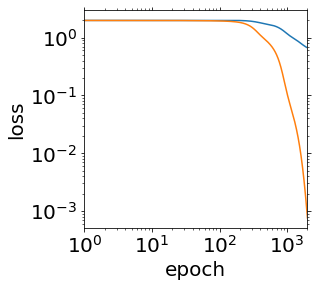

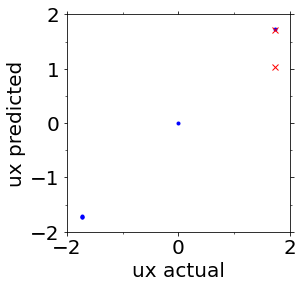

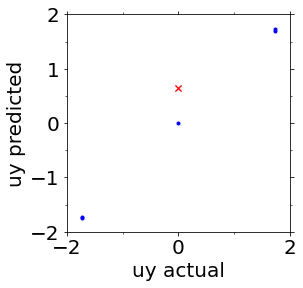

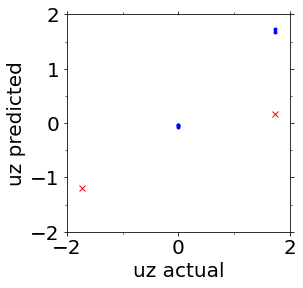

In [24]:
 def main():
        
    nn = NeuralNetwork(
                        hidden_layer_sizes = eval(confParser['neural net']['hidden_layer_sizes']),
                        learning_rate_init = eval(confParser['neural net']['learning_rate_init']),
                        n_iter_no_change   = eval(confParser['neural net']['n_iter_no_change']),
                        tol                = eval(confParser['neural net']['tol']),
                        max_iter           = eval(confParser['neural net']['max_iter']),
                        alpha              = eval(confParser['neural net']['alpha']),
                        hidden_layer_size  = eval(confParser['neural net']['hidden_layer_size']),
                        fully_connected    = eval(confParser['neural net']['fully_connected']),
                        implementation     = eval(confParser['neural net']['implementation']),
                        cnn                = eval(confParser['neural net']['cnn']),
                        n_channels         = eval(confParser['neural net']['n_channels']),
                        kernel_size        = eval(confParser['neural net']['kernel_size']),
                        activation         = eval(confParser['neural net']['activation']),
                        number_hidden_layers = eval(confParser['neural net']['number_hidden_layers']),
                        verbose            = True 
                    )
    nn.Parse( path  = confParser['neural net']['input_path'],
              nruns = eval(confParser['neural net']['nruns']))
    nn.Combine()
#     tmp = nn.df_combined.set_index('id')
#    display(nn.perAtomData.iloc[:13])
#    nn.PrintDensityMap(6,'density6.xyz')
    #    
#    nn.PCA()
#    nn.Spectra()
#    nn.TrainClassifier(np.c_[nn.perAtomData.defect_label].astype(int))
    nn.ConvNetworkClassifier( np.c_[ nn.perAtomData.defect_label ].astype( int ) )
    
#    return nn
    #--- filter data
    train_type = int(eval(confParser['neural net']['train_type']))
    filtr      = {
                     0: nn.perAtomData.defect_label == 1.0, #--- only non-crystalline atoms
                     1: np.ones(len(nn.perAtomData),dtype=bool), #--- every atom
                    }[train_type]
    stratify   = {
                    0:None,
                    1:np.c_[nn.perAtomData.defect_label].astype(int), #--- ensure same ratio in test and training
                    }[train_type]


    
    #--- train
    nn.TrainRegressor(  stratify=stratify,
                        y=np.c_[nn.perAtomData[filtr]['ux uy uz'.split()]],
                        printOvito = True,
                        filtr=filtr,
                     )
    return nn

data = main()

### Plot

In [ ]:
def main():
    if eval(confParser['flags']['RemoteMachine']):
        return
    
    
    script = 'postproc.py test_ncbj_slurm.py'.split()[1]
    number_hidden_layers  = dict(zip(range(4),[1,2,3]))
    n_channels  = dict(zip(range(4),[8,16,32,64]))
    activations = dict(zip(range(20),['linear']))
    runs = [1]
    
    legend = utl.Legends()
    legend.Set(fontsize=14,bbox_to_anchor=(1, 0.3, 0.5, 0.5))
    symbols = utl.Symbols()
    
    nphi = len(number_hidden_layers)
    #---
    count = 0
    ax = utl.PltErr(None, None, Plot=False )
    for key_n in number_hidden_layers:
        number_hidden_layer = number_hidden_layers[key_n]
        if number_hidden_layer != 3:
            continue
        for key_c in n_channels:
            n_channel = n_channels[key_c]
#             if n_channel != 4:
#                 continue
            for key_a in activations:
                activation = activations[key_a]

        #---	
                path = 'neuralNet/ni/keras/20x20/cnn/layer%s/channel%s/activation%s'%(key_n,key_c,key_a) #--- change job name
                for irun in runs:
                    data = np.loadtxt('%s/Run%s/png/loss.txt'%(path,irun))

                    epoch = data[:,0]
                    loss = data[:,1]
                    val_loss = data[:,2]

                    utl.PltErr(epoch, loss,#val_loss,
                       attrs=symbols.GetAttrs(count=count%7,nevery=1000,
                            label='%s layers, %s channels, act. %s'%(number_hidden_layer,n_channel,activation)), 
                               Plot=False,
                               ax=ax,
                               )
                count += 1
    ax = utl.PltErr(None, None,
                       yscale='log',xscale='log',
                       xstr='epoch',ystr='training loss',
#                     ylim=(1e-1,1e1),
                    ax=ax,
                    legend=legend.Get(),
                       title='png/training_loss.png',
                   )


main()

## test example: 2d

In [ ]:
# import numpy as np
# y=np.c_[[1.725966,1.725967],
#             [-1.725966,1.725967],
#             [-1.725966,-1.725967],
#             [1.725966,-1.725967],
#            ].T

# X=np.concatenate([list(map(lambda x:np.load('png/descriptor%s.npy'%x).flatten(),range(4)))],axis=1)

# #--- zscore
# scaler = StandardScaler()
# scaler.fit(X)
# X_transfrmd = scaler.transform( X )

# X_train_transfrmd, X_test_transfrmd, y_train, y_test = train_test_split(X_transfrmd, y, test_size=0.25)
# print(y_test)


# print(X_train_transfrmd.shape)

### fully connected in sklearn

In [ ]:

# #        pdb.set_trace()
# #--- tune parameters

# #--- train
# mlp = MLPRegressor(random_state=1,
# #                    verbose=True,
#                    n_iter_no_change=100000,
#                     max_iter=10000,
#                    hidden_layer_sizes=(1000,1000),
# #                    shuffle=False,
# #                     alpha=1e-1,

#                   )
# mlp.fit(X_train_transfrmd,y_train)

# #--- validate
# !mkdir png
# utl.PltErr(range(len(mlp.loss_curve_)), mlp.loss_curve_,
#            attrs={'fmt':'-'},
#            yscale='log',xscale='log',
# #           xlim=(1,self.max_iter[0]),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

# # #         pdb.set_trace()
# y_pred =mlp.predict(X_test_transfrmd)        
# y_pred_train = mlp.predict(X_train_transfrmd)        
# for idime, xstr in zip(range(2),'ux uy'.split()):
#     ax = utl.PltErr(None,None,Plot=False)
#     #
#     utl.PltErr(y_test[:,idime],y_pred[:,idime],
#                attrs={'fmt':'x','color':'red','zorder':10,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(y_train[:,idime],y_pred_train[:,idime],
#                attrs={'fmt':'.','color':'blue','zorder':1,'markersize':6},
#                ax=ax,
#                Plot = False,

#               )
#     #
#     utl.PltErr(None,None,Plot=False,
#                    title='png/scatter%s.png'%idime,
#                     ax=ax,
#                xstr='%s actual'%xstr,ystr='%s predicted'%xstr,
#                xlim=(-3,3),ylim=(-3,3),
#                    )




In [ ]:
# mlp.best_loss_, mlp.loss_

In [ ]:
# ux,uy=mlp.predict(X_test_transfrmd)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# ux,uy

In [ ]:
# ax = utl.PltErr(None,None,Plot=False)

# for i in range(2):
#     utl.PltErr(range(data.descriptors[0,:].shape[0]),data.descriptors[i,:],
#               attrs={'fmt':'-'},#,'color':'C0'},
#                xscale='log',yscale='log',
#                ax=ax,
#                Plot=False,
#               )

# utl.PltErr(range(data.descriptors[100,:].shape[0]),data.descriptors[100,:],
#           attrs={'fmt':'-','color':'C0'},
#            xscale='log',yscale='log',
#            ax=ax,
#            Plot=False,
#           )


In [ ]:
# data.Spectra(nrows=100)

In [ ]:
# from sklearn.neural_network import MLPRegressor
# from sklearn.datasets import make_regression
# from sklearn.model_selection import train_test_split
# X, y = make_regression(n_samples=200, random_state=1)
# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     random_state=1)
# regr = MLPRegressor(verbose=False,
#                     random_state=1, 
# #                     learning_rate='adaptive',
# #                    early_stopping=True, 
#                      n_iter_no_change=1, 
#                     tol=1e-2,
#                      max_iter=10000000,
# #                     solver='sgd',
#                    ).fit(X_train, y_train)
# regr.tol


### fully connected in keras

In [ ]:
# #--- The network architecture
# model = keras.Sequential([
#     layers.Dense(512), #activation="relu"),
# #     layers.Dense(1000), #activation="relu"),
#     layers.Dense(2) #, activation="relu")
#     ])

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam() #learning_rate=1e-4)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- Preparing the image data
# # train_images = train_images.reshape((60000, 28 * 28))
# # train_images = train_images.astype("float32") / 255
# # test_images = test_images.reshape((10000, 28 * 28))
# # test_images = test_images.astype("float32") / 255

# #--- “Fitting” the model X_train_transfrmd,y_train
# model.fit(X_train_transfrmd, y_train, 
#             validation_data=(X_test_transfrmd, y_test),

#           epochs=100, verbose=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,100),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

### cnn

In [ ]:
# tf.random.set_random_seed(812)

# shape=(300,300,1)
# kernel_size = (3,3)
# epochs = 1000
# activation = ['linear','sigmoid','relu'][0]
# padding='same'
# filters = 1
# #
# ndime = y_train.shape[1]
# n_train = X_train_transfrmd.shape[0]
# n_test = X_test_transfrmd.shape[0]
# assert shape[0]*shape[1]*shape[2] == X_train_transfrmd.shape[1]
# inputs = keras.Input(shape=shape)
# #
# x = layers.Conv2D(filters=filters, kernel_size=kernel_size,activation=activation,padding=padding)(inputs)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=2*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=4*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# # x = layers.AveragePooling2D(pool_size=2)(x)
# # x = layers.Conv2D(filters=8*filters, kernel_size=kernel_size,activation=activation,padding=padding)(x)
# x = layers.Flatten()(x)
# outputs = layers.Dense( ndime, activation=activation)(x)

# #--- The network architecture
# model = keras.Model(inputs=inputs, outputs=outputs)

# print(model.summary())

# #--- The compilation step
# optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,epsilon=1e-08)
# model.compile( optimizer=optimizer,#"rmsprop",
#                loss="mean_squared_error",#"sparse_categorical_crossentropy",
#                metrics=["mse"]
#              )

# #--- save best model 
# callbacks=[keras.callbacks.ModelCheckpoint( filepath='png/convnet_from_scratch.keras',  
#                                            monitor="val_loss",
#                                            save_freq=10,
#                                             save_best_only=True)]

# #--- “Fitting” the model X_train_transfrmd,y_train
# X_train_reshaped = X_train_transfrmd.reshape((n_train,shape[0],shape[1],1))
# X_test_reshaped = X_test_transfrmd.reshape((n_test,shape[0],shape[1],1))
# model.fit(X_train_reshaped, y_train, 
#             validation_data=(X_test_reshaped, y_test),
#             #callbacks=callbacks,
#           epochs=epochs, verbose=False, shuffle=False)#, batch_size=128)

# loss = model.history.history['loss']
# val_loss = model.history.history['val_loss']
# #--- validate

# ax = utl.PltErr(range(len(val_loss)), val_loss,
#            attrs={'fmt':'-'}, Plot=False,
#           )
# utl.PltErr(range(len(loss)), loss,
#            attrs={'fmt':'-'},
#            ax=ax,
#            yscale='log',xscale='log',
#            xlim=(1,epochs),
#            xstr='epoch',ystr='loss',
#            title='png/loss.png',
#           )

In [ ]:
#best_model = keras.models.load_model("png/convnet_from_scratch.keras")


In [ ]:
# ux,uy=best_model.predict(X_test_reshaped)[0]
# ax=utl.PltErr([0,ux],[0,uy],
#               Plot=False
#           )
# utl.PltErr([0,y_test[0][0]],[0,y_test[0][1]],
#            xlim=(-3,3),ylim=(-3,3),
#             ax=ax
#           )

In [ ]:
# (ux,uy), y_test[0]